# Определение стоимости автомобилей

# *Описание проекта*

Сервис по продаже автомобилей с пробегом **«Не бит, не крашен»** разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей.<br>Вам нужно построить модель для определения стоимости.
<br>Заказчику важны:
- качество предсказания;
- скорость предсказания;
- время обучения.

# Описание данных

<br>**Признаки:**<br>
<ul><em>DateCrawled</em> — дата скачивания анкеты из базы</ul>
<ul><em>VehicleType</em> — тип автомобильного кузова</ul>
<ul><em>RegistrationYear</em> — год регистрации автомобиля</ul>
<ul><em>Gearbox</em> — тип коробки передач</ul>
<ul><em>Power</em> — мощность (л. с.)</ul>
<ul><em>Model</em> — модель автомобиля</ul>
<ul><em>Kilometer</em> — пробег (км)</ul>
<ul><em>RegistrationMonth</em> — месяц регистрации автомобиля</ul>
<ul><em>FuelType</em> — тип топлива</ul>
<ul><em>Brand</em> — марка автомобиля</ul>
<ul><em>NotRepaired</em> — была машина в ремонте или нет</ul>
<ul><em>DateCreated</em> — дата создания анкеты</ul>
<ul><em>NumberOfPictures</em> — количество фотографий автомобиля</ul>
<ul><em>PostalCode</em> — почтовый индекс владельца анкеты (пользователя)</ul>
<ul><em>LastSeen</em> — дата последней активности пользователя</ul>
<br><strong>Целевой признак:</strong><br>
<em>Price</em> — цена (евро)

## Загрузка и подготовка данных

### Импорт библиотек

In [1]:
import pandas as pd
import time
import datetime
import os
import numpy as np
import math
from pandas.api.types import is_string_dtype, is_numeric_dtype

from matplotlib import pyplot
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV

from xgboost.sklearn import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

pd.set_option('display.float_format', lambda x: '%.3f' % x)
pyplot.style.use('seaborn-deep')
STATE = 12345

In [2]:
# напишем функцию для поиска файла на локальном диске: 
def find(name, path):
    '''
    Function to find the data file stored locally.
    Takes name of the file and root directory.
    Scanes the local directory tree for the first orrurance of the file.
    '''
    for root, dirs, files in os.walk(path):
        if name in files:
            return os.path.join(root, name)

In [3]:
# найдем файл на диске или онлайн: 

online_path = 'datasets'
offline_path = '/home/alex/Документы/'
file = 'autos.csv'


try:
    df = pd.read_csv(f'/{online_path}/{file}', parse_dates=[0, 12, 15])
except FileNotFoundError:
    df = pd.read_csv(find(file, offline_path), parse_dates=[0, 12, 15])
    print(f"Файл {file} найден на локальном диске.")
else:
    print(f"Файл {file} открыт в режиме online.")

Файл autos.csv открыт в режиме online.


### Развёрнутая сводка по датафрейму

In [4]:
start = "\033[1m"
end = "\033[0;0m"
print(
        f"Внешний вид первых пяти строк датафрейма {start}{str(file).split('.')[0].upper()}{end}:"
    )
display(df.head())
print()
print(f"Размер датафрейма {start}{str(file).split('.')[0].upper()}{end}: \
        \nколичество строк - {df.shape[0]}, \nколичество столбцов - {df.shape[1]}."
          )
print()
print(
        f"Развернутая сводка датафрейма {start}{str(file).split('.')[0].upper()}{end} \nпо наименованию столбцов, типу данных, ненулевых значениях и объему памяти:"
    )
print()
df.info(show_counts=True, memory_usage='deep')
print()
print(f"Пропуски в столбцах датафрейма {start}{str(file).split('.')[0].upper()}{end}:")
display(df.isna().sum())

print(
        f"Статистические данные по столбцам датафрейма {start}{str(file).split('.')[0].upper()}{end}, содержащим численные значения:"
    )
display(df.describe(include=np.number))
print()
print(
        f"Уникальные значения столбцов датафрейма {start}{str(file).split('.')[0].upper()}{end}, содержащих категориальные значения:"
    )
for column in df.columns: 
    if is_string_dtype(df[column]):
        print(f'    Наименование столбца: {start}{column}{end}')
        print(f'        {sorted([str(x) for x in df[column].unique()])}')
        print()


Внешний вид первых пяти строк датафрейма AUTOS:


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21



Размер датафрейма AUTOS:         
количество строк - 354369, 
количество столбцов - 16.

Развернутая сводка датафрейма AUTOS 
по наименованию столбцов, типу данных, ненулевых значениях и объему памяти:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand   

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Статистические данные по столбцам датафрейма AUTOS, содержащим численные значения:


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000,354369.000,354369.000,354369.000,354369.000,354369.000,354369.000
mean,4416.657,2004.234,110.094,128211.173,5.715,0.000,50508.689
std,4514.159,90.228,189.850,37905.342,3.726,0.000,25783.096
min,0.000,1000.000,0.000,5000.000,0.000,0.000,1067.000
25%,1050.000,1999.000,69.000,125000.000,3.000,0.000,30165.000
50%,2700.000,2003.000,105.000,150000.000,6.000,0.000,49413.000
75%,6400.000,2008.000,143.000,150000.000,9.000,0.000,71083.000
max,20000.000,9999.000,20000.000,150000.000,12.000,0.000,99998.000



Уникальные значения столбцов датафрейма AUTOS, содержащих категориальные значения:
    Наименование столбца: VehicleType
        ['bus', 'convertible', 'coupe', 'nan', 'other', 'sedan', 'small', 'suv', 'wagon']

    Наименование столбца: Gearbox
        ['auto', 'manual', 'nan']

    Наименование столбца: Model
        ['100', '145', '147', '156', '159', '1_reihe', '1er', '200', '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe', '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900', '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8', 'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea', 'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo', 'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora', 'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse', 'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma', 'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee', 'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt',

### *Промежуточные выводы*

1. Датафрейм содержит довольно большое количество пропусков. Часть из них может быть заполнена, часть необходимо будет отбросить. Обработку пропусков выполним в качестве последнего шага подготовки данных. 
2. **Типы данных**: столбцы, содержащие полные данные о дате были преобразованы на этапе загрузки датафрейма. Столбец  __*PostalCode*__ имеет тип данных __*int64*__, однако индекс должен использоваться не как числовое значение, а в качестве категорийной переменной. При этом индекс стоит укрупнить, чтобы не получить чрезмерно много значений в данной переменной. Такое же преобразование потребуется данным столбца __*RegistrationYear*__ после обработки.  
3. **Значения столбцов**: 
- __*Price*__ - минимальное значение - 0, медианное значение 4500, а среднее 2700, что говорит о наличии негативного перекоса распределения даных, максимальное значение - 20000. Необходимо проверить нижний порог цен. Скорее всего, стоимость указана не в рублях, а долларах или евро.
- __*RegistrationYear*__ - минимальное значение 1000 (хотел бы я увидеть этот автомобиль) - необходимо проанализировать данные этого столбца на релевантность и отбросить те строки, где год указан не корректно (min и max). 
- __*Power*__ - как и предыдущий столбец, содержит странные значения минимума и максимума. 
- __*Kilometer*__ - на первый взгляд не содержит значений, которые вызывали бы вопросы, однако имеет смысл проверить корреляцию между годом регистрации автомобиля, километрами пробега и стоимостью, а таке километрами пробега и данными о ремонте автомобиля. 
- __*RegistrationMonth, LastSeen, DateCreated*__ и __*NumberOfPictures*__ - 4 столбца, которые не несут полезной информации для модели машинного обучения. 
- Столбцы __*Model, FuelType, VehicleType, Gearbox*__ - содержит значения 'nan', которые могут быть отброшены. 
- __*NotRepaired*__ - содержит пропуски, которые можно заменить на значение False. 
- __*Brand*__ - содержит особое значение 'sonstige_autos' (*нем.* иные автомобили). Стоит обратить внимание на эту категорию. И, возможно, отбросить. 

### Обработка столбцов

#### Изменение типа данных PostalCode и сокращение индекса до 3-х знаков

In [5]:
# изменим тип данных на строку и оставим только первые три знака: 
df['PostalCode'] = df.PostalCode.astype("string")
df['PostalCode'] = df.PostalCode.str.slice(stop=3)

In [6]:
# вернем тип данных к числовому: 
df['PostalCode'] = df.PostalCode.astype("int32")

#### Удаление неинформативных даных

In [7]:
df.drop([
    'DateCrawled', 'RegistrationMonth', 'LastSeen', 'DateCreated',
    'NumberOfPictures'
],
    axis=1,
    inplace=True)

In [8]:
# проверим полученный результат: 
df.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'FuelType', 'Brand', 'NotRepaired', 'PostalCode'],
      dtype='object')

#### RegistrationYear

In [9]:
# рассмотрим уникальные значения столбца RegistrationYear:
print(sorted(df.RegistrationYear.unique()))

[1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500, 1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000, 3200, 3500, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555, 5600, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200, 8455, 8500, 8888, 9000, 9229, 9450, 9996, 9999]


Так как речь идет о рынке Германии, то можно предположить, что возможно наличие раритетных автомобилей в выборке. Поэтому диапазон от 1910 до 2019 выглядит достаточно правдоподобным. Однако, такого рода автомобили могут быть малочисленны и иметь при этом очень высокую цену (если это коллекционный экземпеляр) или наоборот - крайне низкую цену, что будет вести к искажению работы модели. Рассмотрим распределение автомобилей в этом диапазоне. 

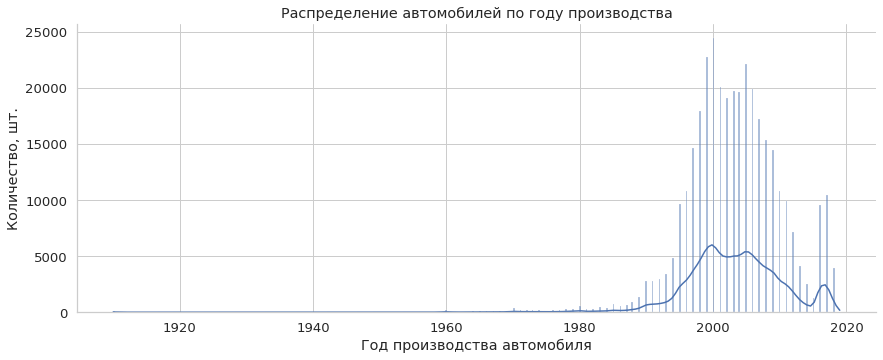

In [10]:
# построим график распределений для столбца года производства автомобиля:
sns.set_theme(style="whitegrid", font_scale=1.2)
sns.displot(
    x='RegistrationYear',
    kde=True,
    data=df.query('RegistrationYear >= 1910 & RegistrationYear <= 2019'),
    height=5,
    aspect=2.5,
    legend=False
).set(
    title='Распределение автомобилей по году производства',
    xlabel='Год производства автомобиля',
    ylabel='Количество, шт.')
pyplot.show()

Действительно график указывает на целесообразный диапазон 1990-2019 включительно. Отбросим строки со значениями вне этого диапазона. 

In [11]:
df = df.query('1989 < RegistrationYear < 2016')

In [12]:
# рассмотрим уникальные значения столбца RegistrationYear:
print(sorted(df.RegistrationYear.unique()))

[1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]


#### Price

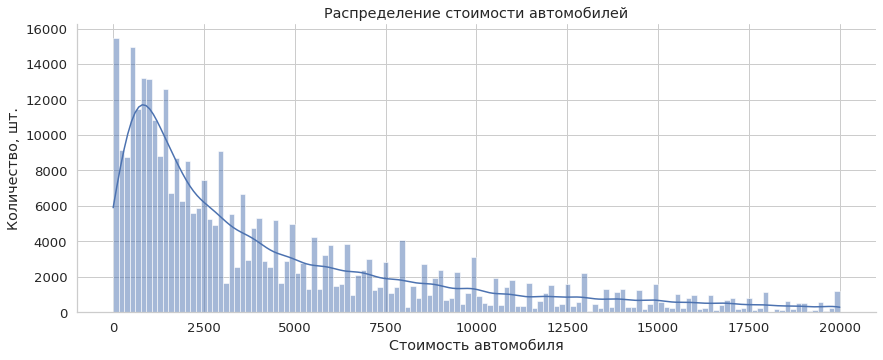

In [13]:
# построим график распределений для столбца цены:
sns.set_theme(style="whitegrid", font_scale=1.2)
sns.displot(x='Price', kde=True, data=df, height=5, aspect=2.5,
            legend=False).set(title='Распределение стоимости автомобилей',
                              xlabel='Стоимость автомобиля',
                              ylabel='Количество, шт.')
pyplot.show()

Распределение стоимости подержаных автомобилей в целом выглядит достаточно логично - количество дешевых автомобилей выше количества дорогих автомобилей. Однако достаточно большое количество автомобилей находятся в ценовом диапазоне около 0 евро. Чего быть не должно. Логически обоснованная цена подержанного автомобиля не должна быть ниже 400 евро (около 30 тыс. рублей). Рассмотрим их количество и отбросим все варианты c ценой до 400 евро.

In [14]:
# проверим количество записей с ценой менее 400 евро:
print(
    f"Процент автомобилей стоимостью до 400 евро: {round(df.shape[0]/df.query('Price < 400').Price.count(), 2)}%"
)

Процент автомобилей стоимостью до 400 евро: 12.01%


In [15]:
# отбросим автомобили с ценой до 400 евро:
df.drop(df.index[df['Price'] < 400], inplace=True)

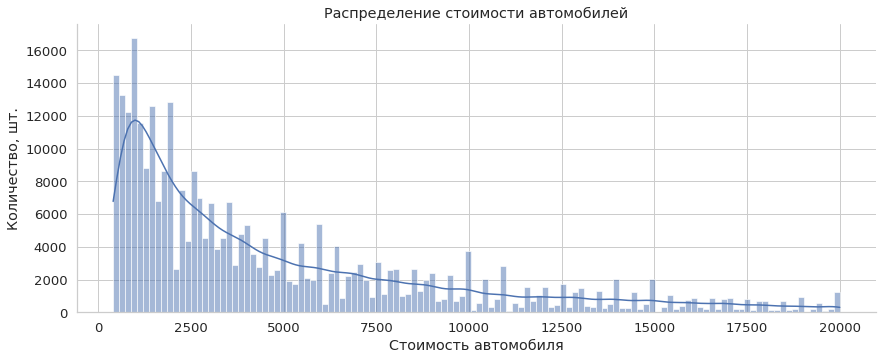

In [16]:
# обновим график распределений для столбца цены:
sns.set_theme(style="whitegrid", font_scale=1.2)
sns.displot(x='Price', kde=True, data=df, height=5, aspect=2.5,
            legend=False).set(title='Распределение стоимости автомобилей',
                              xlabel='Стоимость автомобиля',
                              ylabel='Количество, шт.')
pyplot.show()

#### Power

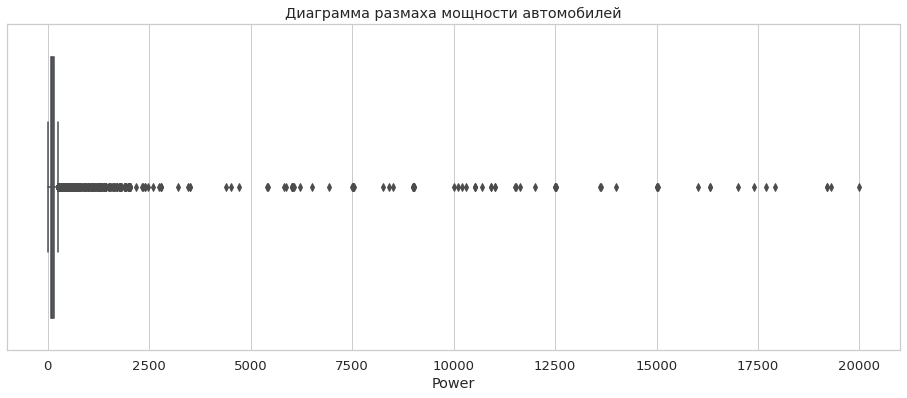

In [17]:
# построим ящик с усами для столбца мощности автомобилей:
fig, ax = pyplot.subplots(figsize=(16, 6))
ax = sns.boxplot(x=df["Power"]).set(title='Диаграмма размаха мощности автомобилей');

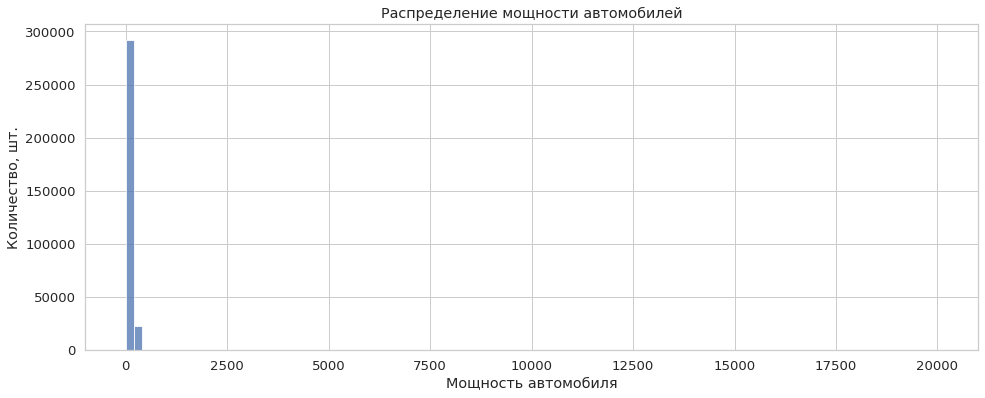

In [18]:
# построим график распределений для столбца мощности:
fig, ax = pyplot.subplots(figsize=(16, 6))
ax = sns.histplot(x='Power', data=df, bins=100,
                  legend=False).set(title='Распределение мощности автомобилей',
                                    xlabel='Мощность автомобиля',
                                    ylabel='Количество, шт.')
pyplot.show()

Очевидно, что данные содержат большое количество выбросов как по нижней, так и по верхней границам, т.к. даже мощность современных суперкаров не превышает 700 л.с.

In [19]:
# отбросим все значения ниже 600, т.к. не думаю, что суперкар даже подержанный может стоить 20 тыс. евро: 
df = df.query('Power < 600')

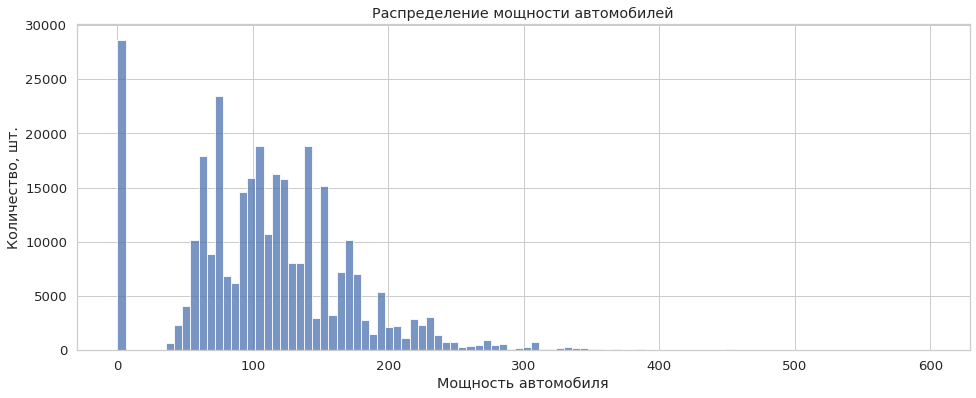

In [20]:
fig, ax = pyplot.subplots(figsize=(16, 6))
ax = sns.histplot(x='Power', data=df, bins=100,
                  legend=False).set(title='Распределение мощности автомобилей',
                                    xlabel='Мощность автомобиля',
                                    ylabel='Количество, шт.')
pyplot.show()

Очевидно, что логичные границы находятся в диапазоне от 50 до 300 л.с. Отбросим все значения за рамками данного диапазона. 

In [21]:
df = df.query('50 < Power < 300')

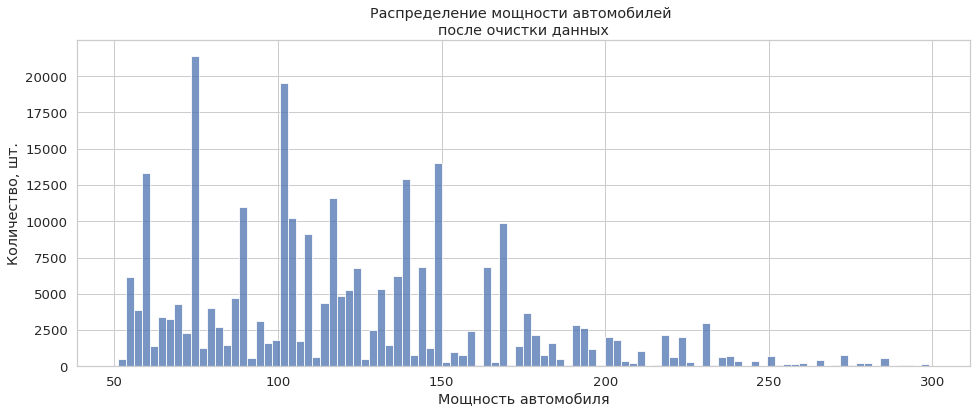

In [22]:
fig, ax = pyplot.subplots(figsize=(16, 6))
ax = sns.histplot(x='Power', data=df, bins=100,
                  legend=False).set(title='Распределение мощности автомобилей \nпосле очистки данных',
                                    xlabel='Мощность автомобиля',
                                    ylabel='Количество, шт.')
pyplot.show()

#### Kilometer

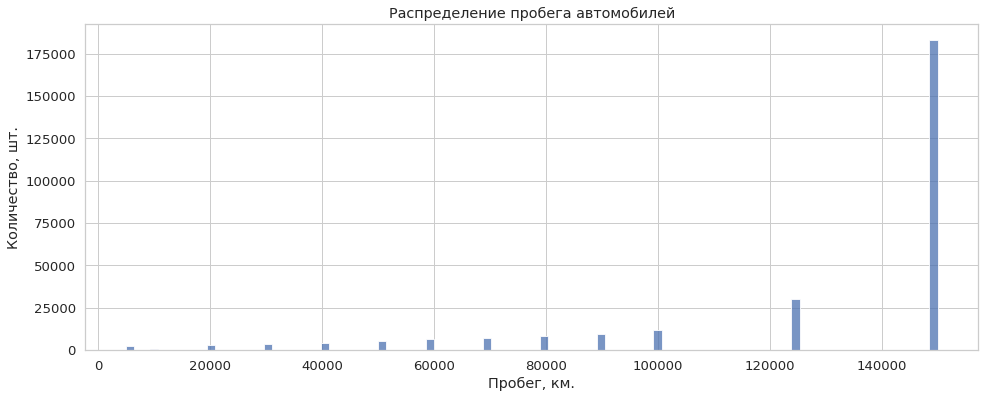

In [23]:
# построим график распределения пробега автомобилей датасета: 
fig, ax = pyplot.subplots(figsize=(16, 6))
ax = sns.histplot(x='Kilometer', data=df, bins=100,
                  legend=False).set(title='Распределение пробега автомобилей',
                                    xlabel='Пробег, км.',
                                    ylabel='Количество, шт.')
pyplot.show()

In [24]:
# проверим уникальные значения: 
df.Kilometer.value_counts()

150000    183217
125000     30015
100000     11919
90000       9771
80000       8562
70000       7434
60000       6546
50000       5449
40000       4298
30000       3676
20000       3022
5000        2215
10000        800
Name: Kilometer, dtype: int64

Данные о пробеге не содержат каких-то специфичных значений. Однако есть явный перекос в сторону автомобилей с большим пробегом. Для удобства переведем значения из километров в тысячи километров. 

In [25]:
df['Kilometer'] = df['Kilometer'] / 1000

In [26]:
# вернем тип данных к цельночисленному: 
df['Kilometer'] = df.Kilometer.astype("int32")

##### Корреляция числовых столбцов

In [27]:
# отфильтруем числовые столбцы датафрейма: 
numeric_columns = []
for column in df.columns: 
    if is_numeric_dtype(df[column]): 
        numeric_columns.append(column)

Text(0.5, 1.0, 'Тепловая карта корреляции числовых фичей')

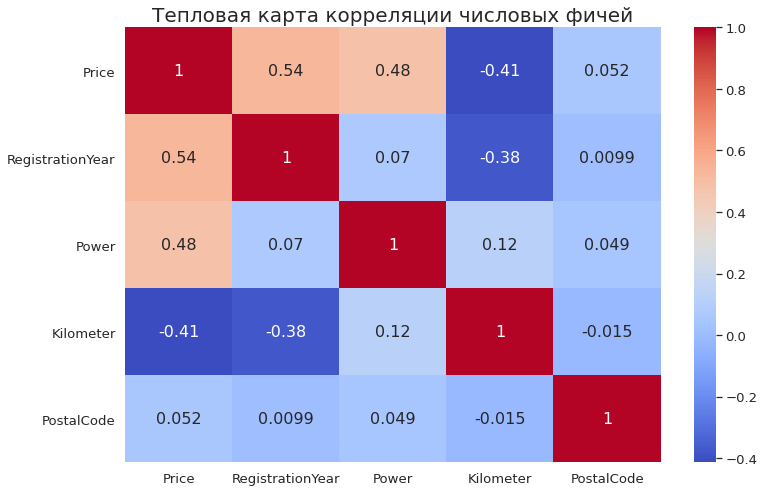

In [28]:
# построим тепловую карту корреляции числовых столбцов: 
fig, ax = pyplot.subplots(figsize=(12, 8))
sns.heatmap(df.loc[:, numeric_columns].corr(method='pearson'),
            annot=True,
            cmap='coolwarm',
            annot_kws={"fontsize": 16}
           )
ax.set_title(f'Тепловая карта корреляции числовых фичей', fontsize=20)

Стоимость автомобиля имеет среднюю корреляцию с годом регистрации автомобиля и мощностью двигателя и среднюю обратную корреляцию с пробегом автомобиля. 

#### Brand

In [29]:
# проверим наличие категории "sonstige_autos": 
df.query('Brand == "sonstige_autos"')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,PostalCode
661,9900,suv,2000,auto,250,NaN,150,lpg,sonstige_autos,no,173
700,6999,sedan,2010,auto,186,NaN,125,petrol,sonstige_autos,no,819
985,500,sedan,2010,manual,101,NaN,70,petrol,sonstige_autos,yes,768
1106,9200,sedan,2005,auto,249,NaN,150,petrol,sonstige_autos,no,954
1274,16990,small,2015,manual,135,NaN,20,petrol,sonstige_autos,no,741
...,...,...,...,...,...,...,...,...,...,...,...
352549,9900,wagon,2011,manual,70,NaN,60,petrol,sonstige_autos,no,864
353867,5000,sedan,2006,manual,175,NaN,125,petrol,sonstige_autos,no,713
353892,7900,bus,2009,NaN,140,NaN,125,gasoline,sonstige_autos,no,972
354062,6000,small,2008,manual,155,NaN,150,petrol,sonstige_autos,no,630


In [30]:
# т.к. не указаны ни модель, ни бренд, очистим датафрейм от этих данных: 
df.drop(df.index[df['Brand'] == "sonstige_autos"], inplace=True)

In [31]:
# проверим полученный результат: 
df.query('Brand == "sonstige_autos"')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,PostalCode


In [32]:
# проверим уникальные значения: 
df.Brand.value_counts()

volkswagen       59188
bmw              31345
opel             29788
mercedes_benz    25667
audi             24993
ford             18707
renault          13196
peugeot           9004
fiat              6901
seat              5226
skoda             4960
mazda             4600
citroen           4049
toyota            4024
nissan            3792
smart             3591
hyundai           3119
mini              3016
volvo             2671
mitsubishi        2360
honda             2345
kia               2115
alfa_romeo        1870
suzuki            1835
chevrolet         1317
chrysler          1101
dacia              821
subaru             585
jeep               542
daihatsu           504
saab               437
land_rover         434
jaguar             377
daewoo             365
rover              333
lancia             329
porsche            307
lada               136
trabant              3
Name: Brand, dtype: int64

#### Model, FuelType, VehicleType, Gearbox

In [33]:
# проверим уникальные значения: 
df.Model.value_counts()

golf                  24045
3er                   16952
other                 16856
astra                  8837
a4                     8762
                      ...  
911                       4
200                       4
i3                        4
rangerover                3
range_rover_evoque        2
Name: Model, Length: 246, dtype: int64

In [34]:
# проверим уникальные значения: 
df.FuelType.value_counts()

petrol      167783
gasoline     87065
lpg           4280
cng            476
hybrid         182
other           44
electric        28
Name: FuelType, dtype: int64

In [35]:
# проверим уникальные значения: 
df.VehicleType.value_counts()

sedan          76558
small          57847
wagon          56801
bus            25415
convertible    17215
coupe          12295
suv             9888
other           2004
Name: VehicleType, dtype: int64

In [36]:
# проверим уникальные значения: 
df.Gearbox.value_counts()

manual    216988
auto       54261
Name: Gearbox, dtype: int64

Модели содаржат большое количество малочисленных авто, которые в дальнейшем будут мешать обучению модели. Рассмотрим 50 минимальных значений и отбросим часть. 

In [37]:
# проверим уникальные значения: 
df.Model.value_counts().nsmallest(50)

range_rover_evoque     2
rangerover             3
samara                 4
911                    4
200                    4
i3                     4
kalina                 5
elefantino             6
kaefer                 7
gl                     8
m_reihe               10
amarok                11
q3                    13
kappa                 13
move                  15
charade               17
materia               17
musa                  21
9000                  21
b_max                 25
145                   25
delta                 26
lodgy                 30
6er                   31
terios                32
lybra                 34
croma                 36
v60                   40
nubira                41
90                    41
lanos                 50
range_rover_sport     51
g_klasse              52
defender              55
crossfire             56
cx_reihe              58
mustang               60
glk                   60
range_rover           65
cayenne               66


In [38]:
# отбросим все марки, которые встречаются реже 50 раз:
value_counts = df['Model'].value_counts()
to_remove = value_counts[value_counts <= 50].index
df['Model'].replace(to_remove, np.nan, inplace=True)

In [39]:
# проверим полученный результат: 
df.Model.value_counts().nsmallest(10)

range_rover_sport    51
g_klasse             52
defender             55
crossfire            56
cx_reihe             58
glk                  60
mustang              60
range_rover          65
cayenne              66
discovery            70
Name: Model, dtype: int64

In [40]:
df = df.dropna(subset=['Model', 'FuelType', 'VehicleType', 'Gearbox'])

#### NotRepaired 

In [41]:
# заменим пропуски на False: 
df.loc[df['NotRepaired'].isna(), ['NotRepaired']] = 'no'

In [42]:
# проверим полученный результат
df['NotRepaired'].unique()

array(['no', 'yes'], dtype=object)

In [43]:
# приведем столбец в бинарный вид: 
df['NotRepaired'] = df['NotRepaired'].map({'yes': 1, 'no': 0})

In [44]:
# проверим полученный результат
df['NotRepaired'].unique()

array([0, 1])

In [45]:
df.info(show_counts=True, memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 241013 entries, 2 to 354368
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             241013 non-null  int64 
 1   VehicleType       241013 non-null  object
 2   RegistrationYear  241013 non-null  int64 
 3   Gearbox           241013 non-null  object
 4   Power             241013 non-null  int64 
 5   Model             241013 non-null  object
 6   Kilometer         241013 non-null  int32 
 7   FuelType          241013 non-null  object
 8   Brand             241013 non-null  object
 9   NotRepaired       241013 non-null  int64 
 10  PostalCode        241013 non-null  int32 
dtypes: int32(2), int64(4), object(5)
memory usage: 83.2 MB


### Разделение данных

In [46]:
# выделим целевой признак: 
target = df.Price

In [47]:
# выделим параметры: 
features = df.drop('Price', axis=1)

In [48]:
# выделим данные для обучения и тестирования:
features_train, features_test, target_train, target_test = train_test_split(
    features,
    target,
    test_size=0.25,
    random_state=STATE)

In [49]:
features_train.isna().sum()

VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
NotRepaired         0
PostalCode          0
dtype: int64

### Разделение датасета по типам

#### One Hot Encoding

In [50]:
# OHE кодирование датасета:
features_train_OHE, features_test_OHE, = pd.get_dummies(
    features_train, drop_first=True), pd.get_dummies(features_test,
                                                     drop_first=True)
display(features_train_OHE.head())
display(features_test_OHE.head())

,RegistrationYear,Power,Kilometer,NotRepaired,PostalCode,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,...,Brand_rover,Brand_saab,Brand_seat,Brand_skoda,Brand_smart,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_volkswagen,Brand_volvo
176974,2005,69,150,0,543,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
271021,2005,200,150,0,357,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
59775,2010,156,70,0,912,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
128687,2002,80,150,0,782,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85902,2002,116,150,0,125,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


,RegistrationYear,Power,Kilometer,NotRepaired,PostalCode,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,...,Brand_rover,Brand_saab,Brand_seat,Brand_skoda,Brand_smart,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_volkswagen,Brand_volvo
334758,2011,95,50,0,666,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
207475,2004,140,150,0,780,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
56592,1997,90,150,1,501,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
341677,2008,140,125,0,402,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
106277,1991,98,150,0,854,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


#### Прямое кодирование категориальных столбцов

In [51]:
# проведем прямое кодирование категориальных столбцов:
encoder = OrdinalEncoder()
encoder.fit(df[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand']])
train_cat_OE = encoder.transform(
    features_train[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand']])
test_cat_OE = encoder.transform(
    features_test[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand']])

In [52]:
# заменим категориальные столбцы на кодированные в новой переменной:
features_train_OE = features_train.copy()
features_test_OE = features_test.copy()
features_train_OE[['VehicleType', 'Gearbox', 'Model', 'FuelType',
                   'Brand']] = train_cat_OE
features_test_OE[['VehicleType', 'Gearbox', 'Model', 'FuelType',
                  'Brand']] = test_cat_OE
display(features_train_OE.head())
display(features_test_OE.head())

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,PostalCode
176974,5.000,2005,1.000,69,73.000,150,2.000,24.000,0,543
271021,2.000,2005,1.000,200,102.000,150,6.000,36.000,0,357
59775,2.000,2010,1.000,156,140.000,70,6.000,25.000,0,912
128687,2.000,2002,1.000,80,181.000,150,6.000,9.000,0,782
85902,0.000,2002,1.000,116,171.000,150,2.000,36.000,0,125


,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,PostalCode
334758,4.000,2011,1.000,95,68.000,50,6.000,22.000,0,666
207475,4.000,2004,1.000,140,102.000,150,2.000,36.000,0,780
56592,1.000,1997,1.000,90,102.000,150,6.000,36.000,1,501
341677,0.000,2008,1.000,140,99.000,125,2.000,10.000,0,402
106277,1.000,1991,1.000,98,102.000,150,6.000,36.000,0,854


#### Сводный датафрейм с использованием технологий OHE и OE

In [53]:
features_train_full = features_train_OHE.copy()
features_test_full = features_test_OHE.copy()

features_train_full[['VehicleType', 'Gearbox', 'Model', 'FuelType',
                     'Brand']] = train_cat_OE
features_test_full[['VehicleType', 'Gearbox', 'Model', 'FuelType',
                    'Brand']] = test_cat_OE

display(features_train_full.head())
display(features_test_full.head())

,RegistrationYear,Power,Kilometer,NotRepaired,PostalCode,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,...,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_volkswagen,Brand_volvo,VehicleType,Gearbox,Model,FuelType,Brand
176974,2005,69,150,0,543,0,0,0,0,1,...,0,0,0,0,0,5.000,1.000,73.000,2.000,24.000
271021,2005,200,150,0,357,0,1,0,0,0,...,0,0,0,1,0,2.000,1.000,102.000,6.000,36.000
59775,2010,156,70,0,912,0,1,0,0,0,...,0,0,0,0,0,2.000,1.000,140.000,6.000,25.000
128687,2002,80,150,0,782,0,1,0,0,0,...,0,0,0,0,0,2.000,1.000,181.000,6.000,9.000
85902,2002,116,150,0,125,0,0,0,0,0,...,0,0,0,1,0,0.000,1.000,171.000,2.000,36.000


,RegistrationYear,Power,Kilometer,NotRepaired,PostalCode,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,...,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_volkswagen,Brand_volvo,VehicleType,Gearbox,Model,FuelType,Brand
334758,2011,95,50,0,666,0,0,0,1,0,...,0,0,0,0,0,4.000,1.000,68.000,6.000,22.000
207475,2004,140,150,0,780,0,0,0,1,0,...,0,0,0,1,0,4.000,1.000,102.000,2.000,36.000
56592,1997,90,150,1,501,1,0,0,0,0,...,0,0,0,1,0,1.000,1.000,102.000,6.000,36.000
341677,2008,140,125,0,402,0,0,0,0,0,...,0,0,0,0,0,0.000,1.000,99.000,2.000,10.000
106277,1991,98,150,0,854,1,0,0,0,0,...,0,0,0,1,0,1.000,1.000,102.000,6.000,36.000


## Обучение моделей на трех типах признаков

### Модель - LinearRegression

In [54]:
# напишем функцию обучения модели линейной регрессии:
def model_train(model, features_train, features_test):
    start = time.time()
    train_rmse = (cross_val_score(model,
                                  features_train_OE,
                                  target_train,
                                  cv=5,
                                  scoring='neg_mean_squared_error').mean() *
                  -1)**0.5
    model.fit(features_train, target_train)
    end = time.time()
    train_time = datetime.timedelta(seconds=(end - start))
    
    print(
        f'Среднее значение RMSE для кроссвалидации модели {model}: {round(train_rmse, 2)}\
    \nВремя обучения: {train_time}')
    print()
    print('********************************************************************************')
    print()
    
    start = time.time()
    prediction = model.predict(features_test)
    end = time.time()
    execution_time = datetime.timedelta(seconds=(end - start))
    
    rmse = mean_squared_error(target_test, prediction, squared=False)
    print(
        f'Среднее значение RMSE для модели {model} на тестовой выборке: {round(rmse, 2)}\
    \nВремя предсказания: {execution_time}')
    model_dict = {
        'Model': model,
        'Train time': train_time.total_seconds(),
        'Predict time': execution_time.total_seconds(),
        'Train RMSE': round(train_rmse, 2),
        'Test RMSE': round(rmse, 2),
    }
    return model_dict

#### Параметры с прямым кодированием

In [55]:
lr_OE = model_train(LinearRegression(), features_train_OE, features_test_OE)

Среднее значение RMSE для кроссвалидации модели LinearRegression(): 2535.31    
Время обучения: 0:00:00.202276

********************************************************************************

Среднее значение RMSE для модели LinearRegression() на тестовой выборке: 2543.01    
Время предсказания: 0:00:00.004614


In [56]:
lr_OE

{'Model': LinearRegression(),
 'Train time': 0.202276,
 'Predict time': 0.004614,
 'Train RMSE': 2535.31,
 'Test RMSE': 2543.01}

#### Параметры после OHE

In [57]:
lr_OHE = model_train(LinearRegression(), features_train_OHE, features_test_OHE)

Среднее значение RMSE для кроссвалидации модели LinearRegression(): 2535.31    
Время обучения: 0:00:02.139215

********************************************************************************

Среднее значение RMSE для модели LinearRegression() на тестовой выборке: 2173.26    
Время предсказания: 0:00:00.100815


In [58]:
lr_OHE

{'Model': LinearRegression(),
 'Train time': 2.139215,
 'Predict time': 0.100815,
 'Train RMSE': 2535.31,
 'Test RMSE': 2173.26}

#### Полностью закодированные параметры

In [59]:
lr_full = model_train(LinearRegression(), features_train_full, features_test_full)

Среднее значение RMSE для кроссвалидации модели LinearRegression(): 2535.31    
Время обучения: 0:00:02.442824

********************************************************************************

Среднее значение RMSE для модели LinearRegression() на тестовой выборке: 2173.26    
Время предсказания: 0:00:00.053469


In [60]:
lr_full

{'Model': LinearRegression(),
 'Train time': 2.442824,
 'Predict time': 0.053469,
 'Train RMSE': 2535.31,
 'Test RMSE': 2173.26}

### Модель - DecisionTreeRegressor

In [61]:
# напишем функцию для моделей DecisionTreeRegressor:
def dt_model_train(model, model_selector, param_grid, features_train, features_test):
    start = time.time()
    grid = model_selector(model,
                          param_grid,
                          cv=5,
                          scoring='neg_mean_squared_error',
                          n_jobs=-1)

    grid.fit(
        features_train,
        target_train,
    )

    end = time.time()
    print('Наилучшие параметры модели на обучающей выборке:')
    print()
    print(grid.best_estimator_)

    train_rmse = (max(grid.cv_results_['mean_test_score']) * -1)**0.5
    train_time = datetime.timedelta(seconds=(end - start))
    
    print(
        f'Среднее значение RMSE для кроссвалидации модели {model}: {round(train_rmse, 2)}\
    \nВремя обучения: {train_time}')
    print()
    print(
        '********************************************************************************'
    )
    print()

    start = time.time()
    prediction = grid.predict(features_test)
    end = time.time()
    execution_time = datetime.timedelta(seconds=(end - start))
    
    rmse = mean_squared_error(target_test, prediction, squared=False)
    print(
        f'Среднее значение RMSE для модели {model} на тестовой выборке: {round(rmse, 2)}\
    \nВремя предсказания: {execution_time}')
    model_dict = {
        'Model': model,
        'Train time': train_time.total_seconds(),
        'Predict time': execution_time.total_seconds(),
        'Train RMSE': round(train_rmse, 2),
        'Test RMSE': round(rmse, 2),
    }
    return model_dict

#### Параметры с прямым кодированием

In [62]:
depth = [x for x in range(10, 15)]
param_grid = [{
    'criterion': ['friedman_mse'],
    'max_depth': depth,
    'random_state': [STATE]
}]

In [63]:
dt_OE = dt_model_train(model=DecisionTreeRegressor(),
                       model_selector=GridSearchCV,
                       param_grid=param_grid,
                       features_train=features_train_OE,
                       features_test=features_test_OE)

Наилучшие параметры модели на обучающей выборке:

DecisionTreeRegressor(criterion='friedman_mse', max_depth=13,
                      random_state=12345)
Среднее значение RMSE для кроссвалидации модели DecisionTreeRegressor(): 1742.67    
Время обучения: 0:00:05.560515

********************************************************************************

Среднее значение RMSE для модели DecisionTreeRegressor() на тестовой выборке: 1724.89    
Время предсказания: 0:00:00.010887


In [64]:
dt_OE

{'Model': DecisionTreeRegressor(),
 'Train time': 5.560515,
 'Predict time': 0.010887,
 'Train RMSE': 1742.67,
 'Test RMSE': 1724.89}

#### Параметры после OHE

In [65]:
dt_OHE = dt_model_train(model=DecisionTreeRegressor(),
                       model_selector=GridSearchCV,
                       param_grid=param_grid,
                       features_train=features_train_OHE,
                       features_test=features_test_OHE)

Наилучшие параметры модели на обучающей выборке:

DecisionTreeRegressor(criterion='friedman_mse', max_depth=14,
                      random_state=12345)
Среднее значение RMSE для кроссвалидации модели DecisionTreeRegressor(): 1741.55    
Время обучения: 0:00:25.706194

********************************************************************************

Среднее значение RMSE для модели DecisionTreeRegressor() на тестовой выборке: 1717.81    
Время предсказания: 0:00:00.062889


In [66]:
dt_OHE

{'Model': DecisionTreeRegressor(),
 'Train time': 25.706194,
 'Predict time': 0.062889,
 'Train RMSE': 1741.55,
 'Test RMSE': 1717.81}

#### Полностью закодированные параметры

In [67]:
dt_full = dt_model_train(model=DecisionTreeRegressor(),
                       model_selector=GridSearchCV,
                       param_grid=param_grid,
                       features_train=features_train_full,
                       features_test=features_test_full)

Наилучшие параметры модели на обучающей выборке:

DecisionTreeRegressor(criterion='friedman_mse', max_depth=14,
                      random_state=12345)
Среднее значение RMSE для кроссвалидации модели DecisionTreeRegressor(): 1719.48    
Время обучения: 0:00:27.199028

********************************************************************************

Среднее значение RMSE для модели DecisionTreeRegressor() на тестовой выборке: 1701.72    
Время предсказания: 0:00:00.076993


In [68]:
dt_full

{'Model': DecisionTreeRegressor(),
 'Train time': 27.199028,
 'Predict time': 0.076993,
 'Train RMSE': 1719.48,
 'Test RMSE': 1701.72}

### Модель - RandomForestRegressor

In [69]:
# напишем функцию для моделей RandomForestRegressor:
def rf_model_train(model, model_selector, param_dist, features_train,
                   features_test, n_iter, verbose):
    start = time.time()
    rand = model_selector(model,
                          param_dist,
                          cv=5,
                          scoring='neg_mean_squared_error',
                          n_iter=n_iter,
                          random_state=STATE,
                          verbose=verbose)

    rand.fit(
        features_train,
        target_train,
    )

    end = time.time()
    print('Наилучшие параметры модели на обучающей выборке:')
    print()
    print(rand.best_estimator_)

    train_rmse = (max(rand.cv_results_['mean_test_score']) * -1)**0.5
    train_time = datetime.timedelta(seconds=(end - start))
    print(
        f'Среднее значение RMSE для кроссвалидации модели {model}: {round(train_rmse, 2)}\
    \nВремя обучения: {train_time}')
    print()
    print(
        '********************************************************************************'
    )
    print()

    start = time.time()
    prediction = rand.predict(features_test)
    end = time.time()
    execution_time = datetime.timedelta(seconds=(end - start))

    rmse = mean_squared_error(target_test, prediction, squared=False)
    print(
        f'Среднее значение RMSE для модели {model} на тестовой выборке: {round(rmse, 2)}\
    \nВремя предсказания: {execution_time}')
    model_dict = {
        'Model': model,
        'Train time': train_time.total_seconds(),
        'Predict time': execution_time.total_seconds(),
        'Train RMSE': round(train_rmse, 2),
        'Test RMSE': round(rmse, 2),
    }
    return model_dict

#### Параметры с прямым кодированием

In [70]:
depth = [x for x in range(18, 20)]
param_dist = {'n_estimators': list(range(50, 53)), 'max_depth': depth}

rf_OE = rf_model_train(model=RandomForestRegressor(),
                       model_selector=RandomizedSearchCV,
                       param_dist=param_dist,
                       features_train=features_train_OE,
                       features_test=features_test_OE,
                       n_iter=2,
                       verbose=1)
rf_OE

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Наилучшие параметры модели на обучающей выборке:

RandomForestRegressor(max_depth=19, n_estimators=52)
Среднее значение RMSE для кроссвалидации модели RandomForestRegressor(): 1463.99    
Время обучения: 0:03:37.743997

********************************************************************************

Среднее значение RMSE для модели RandomForestRegressor() на тестовой выборке: 1444.57    
Время предсказания: 0:00:00.761162


{'Model': RandomForestRegressor(),
 'Train time': 217.743997,
 'Predict time': 0.761162,
 'Train RMSE': 1463.99,
 'Test RMSE': 1444.57}

#### Параметры после OHE

In [71]:
rf_OHE = rf_model_train(model=RandomForestRegressor(),
                       model_selector=RandomizedSearchCV,
                       param_dist=param_dist,
                       features_train=features_train_OHE,
                       features_test=features_test_OHE,
                       n_iter=2,
                       verbose=1)
rf_OHE

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Наилучшие параметры модели на обучающей выборке:

RandomForestRegressor(max_depth=19, n_estimators=50)
Среднее значение RMSE для кроссвалидации модели RandomForestRegressor(): 1481.09    
Время обучения: 0:16:33.200146

********************************************************************************

Среднее значение RMSE для модели RandomForestRegressor() на тестовой выборке: 1466.06    
Время предсказания: 0:00:00.929775


{'Model': RandomForestRegressor(),
 'Train time': 993.200146,
 'Predict time': 0.929775,
 'Train RMSE': 1481.09,
 'Test RMSE': 1466.06}

#### Полностью закодированные параметры

In [72]:
rf_full = rf_model_train(model=RandomForestRegressor(),
                       model_selector=RandomizedSearchCV,
                       param_dist=param_dist,
                       features_train=features_train_full,
                       features_test=features_test_full,
                       n_iter=2,
                       verbose=1)
rf_full

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Наилучшие параметры модели на обучающей выборке:

RandomForestRegressor(max_depth=19, n_estimators=52)
Среднее значение RMSE для кроссвалидации модели RandomForestRegressor(): 1459.48    
Время обучения: 0:18:43.582594

********************************************************************************

Среднее значение RMSE для модели RandomForestRegressor() на тестовой выборке: 1443.72    
Время предсказания: 0:00:00.896445


{'Model': RandomForestRegressor(),
 'Train time': 1123.582594,
 'Predict time': 0.896445,
 'Train RMSE': 1459.48,
 'Test RMSE': 1443.72}

### Модель - CatBoostRegressor

In [73]:
# напишем функцию для моделей CatBoostRegressor:
def cbr_model_train(model,
                    features_train,
                    features_test,
                    learning_rate,
                    random_state,
                    verbose,
                    iterations=200,
                    cat_features=[]):
    start = time.time()
    model = model(learning_rate=learning_rate,
                  iterations=iterations,
                  random_state=random_state,
                  verbose=verbose,
                  cat_features=cat_features)

    model.fit(features_train, target_train)
    end = time.time()
    train_time = datetime.timedelta(seconds=(end - start))
    print(f'Время обучения: {train_time}')

    start = time.time()
    prediction = model.predict(features_test)
    end = time.time()
    execution_time = datetime.timedelta(seconds=(end - start))
    rmse = math.sqrt(mean_squared_error(target_test, prediction))
    print(f'Время предсказания для модели {model}: {execution_time}')
    print(
        f'Среднее значение RMSE для тестовых данных модели {model}: {round(rmse, 2)}'
    )

    model_dict = {
        'Model': model,
        'Train time': train_time.total_seconds(),
        'Predict time': execution_time.total_seconds(),
        'Train RMSE': '-',
        'Test RMSE': round(rmse, 2),
    }
    return model_dict

#### Исходные параметры

In [74]:
cbr_initail_data = cbr_model_train(
    model=CatBoostRegressor,
    features_train=features_train,
    features_test=features_test,
    learning_rate=0.5,
    random_state=STATE,
    cat_features=['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand'],
    verbose=False)
cbr_initail_data

Время обучения: 0:00:08.681508
Время предсказания для модели <catboost.core.CatBoostRegressor object at 0x7f5108a85a00>: 0:00:00.061641
Среднее значение RMSE для тестовых данных модели <catboost.core.CatBoostRegressor object at 0x7f5108a85a00>: 1467.48


{'Model': <catboost.core.CatBoostRegressor at 0x7f5108a85a00>,
 'Train time': 8.681508,
 'Predict time': 0.061641,
 'Train RMSE': '-',
 'Test RMSE': 1467.48}

#### Параметры с прямым кодированием

In [75]:
cbr_OE_data = cbr_model_train(model=CatBoostRegressor,
                              features_train=features_train_OE,
                              features_test=features_test_OE,
                              learning_rate=0.5,
                              random_state=STATE,
                              verbose=False)
cbr_OE_data

Время обучения: 0:00:01.892573
Время предсказания для модели <catboost.core.CatBoostRegressor object at 0x7f5108acbd60>: 0:00:00.010284
Среднее значение RMSE для тестовых данных модели <catboost.core.CatBoostRegressor object at 0x7f5108acbd60>: 1470.37


{'Model': <catboost.core.CatBoostRegressor at 0x7f5108acbd60>,
 'Train time': 1.892573,
 'Predict time': 0.010284,
 'Train RMSE': '-',
 'Test RMSE': 1470.37}

#### Полностью закодированные параметры

In [76]:
cbr_full_data = cbr_model_train(model=CatBoostRegressor,
                                features_train=features_train_full,
                                features_test=features_test_full,
                                learning_rate=0.5,
                                random_state=STATE,
                                verbose=False)
cbr_full_data

Время обучения: 0:00:02.128647
Время предсказания для модели <catboost.core.CatBoostRegressor object at 0x7f5108a818b0>: 0:00:00.048360
Среднее значение RMSE для тестовых данных модели <catboost.core.CatBoostRegressor object at 0x7f5108a818b0>: 1458.37


{'Model': <catboost.core.CatBoostRegressor at 0x7f5108a818b0>,
 'Train time': 2.128647,
 'Predict time': 0.04836,
 'Train RMSE': '-',
 'Test RMSE': 1458.37}

### Модель - LGBMRegressor

In [77]:
# напишем функцию для моделей LGBMRegressor:
def lgbm_model_train(model,
                     features_train,
                     features_test,
                     learning_rate,
                     num_leaves,
                     max_depth,
                     boosting_type,
                     random_state=STATE):
    start = time.time()
    model = model(learning_rate=learning_rate,
                  num_leaves=num_leaves,
                  max_depth=max_depth,
                  boosting_type=boosting_type)

    model.fit(features_train, target_train)
    end = time.time()
    train_time = datetime.timedelta(seconds=(end - start))
    print(f'Время обучения: {train_time}')

    start = time.time()
    prediction = model.predict(features_test)
    end = time.time()
    execution_time = datetime.timedelta(seconds=(end - start))
    rmse = math.sqrt(mean_squared_error(target_test, prediction))
    print(f'Время предсказания для модели {model}: {execution_time}')
    print(
        f'Среднее значение RMSE для тестовых данных модели {model}: {round(rmse, 2)}'
    )

    model_dict = {
        'Model': model,
        'Train time': train_time.total_seconds(),
        'Predict time': execution_time.total_seconds(),
        'Train RMSE': '-',
        'Test RMSE': round(rmse, 2),
    }
    return model_dict

#### Параметры с прямым кодированием

In [78]:
lgbm_OE_data = lgbm_model_train(LGBMRegressor,
                     features_train_OE,
                     features_test_OE,
                     learning_rate=0.05,
                     num_leaves=200,
                     max_depth=10,
                     boosting_type='dart')
lgbm_OE_data

Время обучения: 0:00:03.088516
Время предсказания для модели LGBMRegressor(boosting_type='dart', learning_rate=0.05, max_depth=10,
              num_leaves=200): 0:00:00.096138
Среднее значение RMSE для тестовых данных модели LGBMRegressor(boosting_type='dart', learning_rate=0.05, max_depth=10,
              num_leaves=200): 2165.13


{'Model': LGBMRegressor(boosting_type='dart', learning_rate=0.05, max_depth=10,
               num_leaves=200),
 'Train time': 3.088516,
 'Predict time': 0.096138,
 'Train RMSE': '-',
 'Test RMSE': 2165.13}

#### Полностью закодированные параметры

In [79]:
lgbm_full_data = lgbm_model_train(LGBMRegressor,
                     features_train_full,
                     features_test_full,
                     learning_rate=0.05,
                     num_leaves=200,
                     max_depth=10,
                     boosting_type='dart')
lgbm_full_data

Время обучения: 0:00:04.730854
Время предсказания для модели LGBMRegressor(boosting_type='dart', learning_rate=0.05, max_depth=10,
              num_leaves=200): 0:00:00.181074
Среднее значение RMSE для тестовых данных модели LGBMRegressor(boosting_type='dart', learning_rate=0.05, max_depth=10,
              num_leaves=200): 2136.42


{'Model': LGBMRegressor(boosting_type='dart', learning_rate=0.05, max_depth=10,
               num_leaves=200),
 'Train time': 4.730854,
 'Predict time': 0.181074,
 'Train RMSE': '-',
 'Test RMSE': 2136.42}

### Анализ моделей 

In [123]:
rating = {
    'LinearRegression on Ordinal Encoding':lr_OE,
    'LinearRegression on One Hot Encoding':lr_OHE,
    'LinearRegression on Fully Encoded Data':lr_full,
    'DecisionTreeRegressor on Ordinal Encoding':dt_OE, 
    'DecisionTreeRegressor on One Hot Encoding':dt_OHE, 
    'DecisionTreeRegressor on Fully Encoded Data': dt_full, 
    'RandomForestRegressor on Ordinal Encoding':rf_OE, 
    'RandomForestRegressor on One Hot Encoding':rf_OHE, 
    'RandomForestRegressor on Fully Encoded Data': rf_full, 
    'CatBoostRegressor on Initial Data':cbr_initail_data, 
    'CatBoostRegressor on Ordinal Encoding':cbr_OE_data, 
    'CatBoostRegressor on Fully Encoded Data': cbr_full_data,
    'LGBMRegressor on Ordinal Encoding':lgbm_OE_data, 
    'LGBMRegressor on Fully Encoded Data': lgbm_full_data,
    
}

In [124]:
analysis_df = pd.DataFrame(rating).T

In [125]:
analysis_df

,Model,Train time,Predict time,Train RMSE,Test RMSE
LinearRegression on Ordinal Encoding,LinearRegression(),0.202,0.005,2535.310,2543.010
LinearRegression on One Hot Encoding,LinearRegression(),2.139,0.101,2535.310,2173.260
LinearRegression on Fully Encoded Data,LinearRegression(),2.443,0.053,2535.310,2173.260
DecisionTreeRegressor on Ordinal Encoding,DecisionTreeRegressor(),5.561,0.011,1742.670,1724.890
DecisionTreeRegressor on One Hot Encoding,DecisionTreeRegressor(),25.706,0.063,1741.550,1717.810
DecisionTreeRegressor on Fully Encoded Data,DecisionTreeRegressor(),27.199,0.077,1719.480,1701.720
RandomForestRegressor on Ordinal Encoding,RandomForestRegressor(),217.744,0.761,1463.990,1444.570
RandomForestRegressor on One Hot Encoding,RandomForestRegressor(),993.200,0.930,1481.090,1466.060
RandomForestRegressor on Fully Encoded Data,RandomForestRegressor(),1123.583,0.896,1459.480,1443.720
CatBoostRegressor on Initial Data,<catboost.core.CatBoostRegressor object at 0x7...,8.682,0.062,-,1467.480


In [126]:
a, b = 1, 10
ratings_raw_data = ['Train time', 'Predict time', 'Test RMSE']
new_columns = ['Train Time Rating', 'Predict time Rating', 'Test RMSE Rating']

for col in range(0, 3):

    x, y = analysis_df[ratings_raw_data[col]].min(), analysis_df[
        ratings_raw_data[col]].max()
    analysis_df[new_columns[col]] = (analysis_df[ratings_raw_data[col]] -
                                     x) / (y - x) * (b - a) + a

In [128]:
analysis_df.sort_values(by=['Test RMSE Rating', 'Predict time Rating', 'Train Time Rating'],
                        ascending=[False, True, True])

,Model,Train time,Predict time,Train RMSE,Test RMSE,Train Time Rating,Predict time Rating,Test RMSE Rating
LinearRegression on Ordinal Encoding,LinearRegression(),0.202,0.005,2535.310,2543.010,1.000,1.000,10.000
LinearRegression on Fully Encoded Data,LinearRegression(),2.443,0.053,2535.310,2173.260,1.018,1.475,6.973
LinearRegression on One Hot Encoding,LinearRegression(),2.139,0.101,2535.310,2173.260,1.016,1.936,6.973
LGBMRegressor on Ordinal Encoding,"LGBMRegressor(boosting_type='dart', learning_r...",3.089,0.096,-,2165.130,1.023,1.890,6.906
LGBMRegressor on Fully Encoded Data,"LGBMRegressor(boosting_type='dart', learning_r...",4.731,0.181,-,2136.420,1.036,2.717,6.671
DecisionTreeRegressor on Ordinal Encoding,DecisionTreeRegressor(),5.561,0.011,1742.670,1724.890,1.043,1.061,3.302
DecisionTreeRegressor on One Hot Encoding,DecisionTreeRegressor(),25.706,0.063,1741.550,1717.810,1.204,1.567,3.244
DecisionTreeRegressor on Fully Encoded Data,DecisionTreeRegressor(),27.199,0.077,1719.480,1701.720,1.216,1.704,3.112
CatBoostRegressor on Ordinal Encoding,<catboost.core.CatBoostRegressor object at 0x7...,1.893,0.010,-,1470.370,1.014,1.055,1.218
CatBoostRegressor on Initial Data,<catboost.core.CatBoostRegressor object at 0x7...,8.682,0.062,-,1467.480,1.068,1.555,1.195


### Вывод

Модели градиентного бустинга являются качественной альтернативой медленным "деревянным" моделям. 
<br>Данное исследование показало, что наиболее быстрой была модель линейной регрессии, но она же была и наименее точной в предсказании стоимости автомобиля. 
<br>Наиболее же точная модель: RandomForestRegressor является и самой медленной в обучении. 
<br> При этом CatBoostRegressor лишь незначительно уступает в точности предсказаний, требуя при этом значительно меньше времени и на обучение, и на получение предсказаний. 